In [95]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import tree
from sklearn.metrics import accuracy_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [96]:
df = pd.read_csv(
    'ceneval_mentor_v2.csv',
    encoding='utf-8',
    low_memory=False,
    index_col=0
)
#dc = pd.read_csv(
#    'cenevalPLTPROC.csv',
#    encoding='utf-8',
#    low_memory=False,
#    index_col=0
#)

df.head()

,TIPO_EXA,ANO_NAC,SEXO,LENG_MA,LENG_PA,PLT_PROC,RAZ_RAPT,RAZ_RACT,RAZ_OPT,RAZ_PCUM,...,SER_TVP,SER_TABL,CUARTOS,SER_PC,SER_TV,SER_AUTO,SER_BANO,VAC_RM,DICTAMEN,VECES_EXAM
0,0.0077,0.75,0,0.0,0.0,0.0355,0.0,1.0,1.0,0.0,...,1.0,1.0,0.22,1.0,1.0,1.0,1.0,0.0,0,0
1,0.0705,0.75,1,0.0,0.0,0.0900,1.0,0.0,0.0,0.0,...,0.0,0.0,0.22,1.0,1.0,1.0,1.0,1.0,0,0
2,0.0705,0.75,0,0.0,0.0,0.0900,1.0,1.0,1.0,0.0,...,0.0,0.0,0.41,0.0,1.0,0.0,1.0,0.0,1,0
3,0.0705,0.75,1,0.0,0.0,0.0900,1.0,1.0,1.0,1.0,...,1.0,1.0,0.41,1.0,1.0,0.0,1.0,1.0,1,0
4,0.0705,0.50,0,0.0,0.0,0.0900,1.0,1.0,1.0,0.0,...,0.0,0.0,0.22,1.0,1.0,0.0,1.0,0.0,1,0


In [97]:
#Features and rows
df.shape

(15613, 119)

In [98]:
# "DICTAMEN" measurement
df.groupby("DICTAMEN").size()

DICTAMEN
0    7466
1    8147
dtype: int64

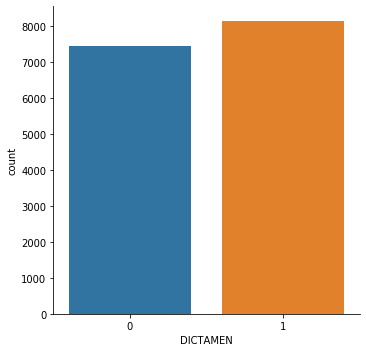

In [99]:
# "DICTAMEN" graph
sb.catplot("DICTAMEN", data=df, kind="count")

In [100]:
#sb.catplot("PLT_PROC", data = dc, kind="count", aspect = 15)

cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(df))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight="balanced")
    for train_fold, valid_fold in cv.split(df):
        f_train = df.loc[train_fold] 
        f_valid = df.loc[valid_fold] 
 
        model = tree_model.fit(X = f_train.drop(['DICTAMEN'], axis=1), 
                               y = f_train["DICTAMEN"]) 
        valid_acc = model.score(X = f_valid.drop(['DICTAMEN'], axis=1), 
                                y = f_valid["DICTAMEN"]) 
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

dd = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
dd = dd[["Max Depth", "Average Accuracy"]]
print(dd.to_string(index=False))

In [101]:
# Training arrays and features
y_train = df['DICTAMEN']
x_train = df.drop(["DICTAMEN"], axis=1).values 

In [102]:
# Decision tree
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
    min_samples_split=20,
    min_samples_leaf=5,
    max_depth = 10,
    class_weight="balanced")
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [103]:
# Image tree (dot)
with open(r"tree.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = True,
                              feature_names = list(df.drop(["DICTAMEN"], axis=1)),
                              class_names = ["AUN NO SATISFACTORIO", "SATISFACTORIO"],
                              rounded = True,
                              filled= True )

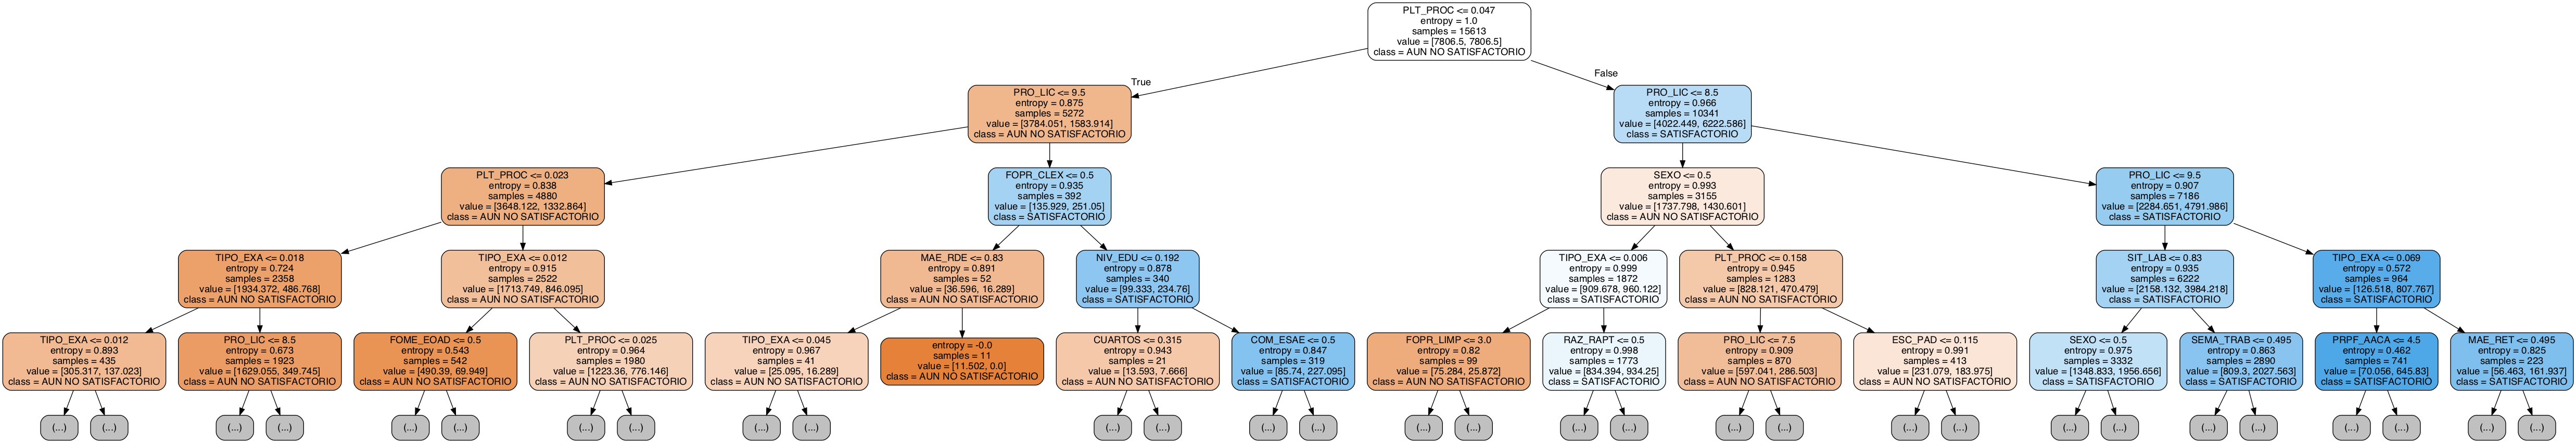

In [104]:
# Image tree (.png)
from PIL import Image
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])
PImage("tree.png")

In [105]:
# Desicion Tree Accuracy
accuracy = round(decision_tree.score(x_train, y_train) * 100, 2)
print(accuracy)

73.57


In [112]:
x_test= df.sample() 
print(x_test)
y_pred = decision_tree.predict(x_test.drop(["DICTAMEN"], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(["DICTAMEN"], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

      TIPO_EXA  ANO_NAC  SEXO  LENG_MA  LENG_PA  PLT_PROC  RAZ_RAPT  RAZ_RACT  \
7075    0.0394     0.75     1      0.0      0.0     0.022       0.0       1.0   

      RAZ_OPT  RAZ_PCUM  ...  SER_TVP  SER_TABL  CUARTOS  SER_PC  SER_TV  \
7075      1.0       0.0  ...      0.0       0.0     0.41     1.0     1.0   

      SER_AUTO  SER_BANO  VAC_RM  DICTAMEN  VECES_EXAM  
7075       0.0       1.0     1.0         0           0  

[1 rows x 119 columns]
Prediccion: [0]
Probabilidad de Acierto: 89.72%
